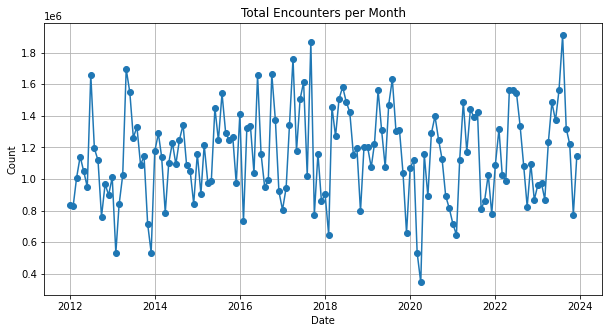

ADF Statistic: -3.4430
p-value: 9.5788e-03


/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/storage/home/rnl5148/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          log_count   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -14.312
Date:                            Thu, 30 Oct 2025   AIC                             38.623
Time:                                    10:19:49   BIC                             52.434
Sample:                                01-01-2012   HQIC                            44.230
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1759      0.089      1.967      0.049       0.001       0.351
ma.L1         -1.0755      0.073   

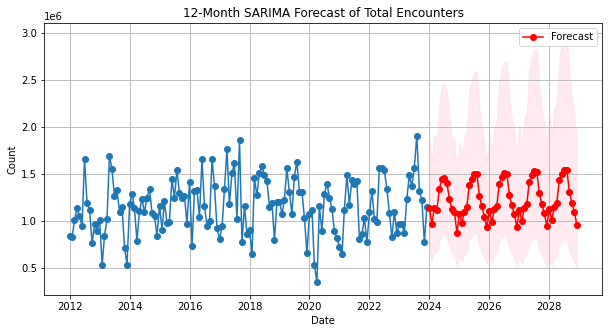

In-sample MAE: 23,899,251.63
In-sample RMSE: 283,704,666.09


In [10]:
import os

# Set the correct Java path for PySpark
os.environ["JAVA_HOME"] = "/storage/icds/RISE/sw8/jdk-20.0.1"
os.environ["PATH"] = os.path.join(os.environ["JAVA_HOME"], "bin") + ":" + os.environ["PATH"]


import pandas as pd 
import numpy as np 
import math 
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt  
import sklearn as sk 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import pyspark 
from pyspark import SparkContext 
from pyspark.sql import SparkSession 
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType 
from pyspark.sql.functions import col, column 
from pyspark.sql.functions import expr 
from pyspark.sql.functions import split 
from pyspark.sql import Row
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

ss=SparkSession.builder.master("local").appName("DS340 Project").getOrCreate()
ss.sparkContext.setCheckpointDir("~/scratch")

staffing_schema = StructType([
    StructField("year", IntegerType(), True),
    StructField("oshpd_id", IntegerType(), True),
    StructField("county_Name", IntegerType(), False),
    StructField("er_service_level_desc", IntegerType(), False),
    StructField("type", IntegerType(), False),
    StructField("count", IntegerType(), True)
])

df_spark = ss.read.csv("EncountersByFacility.csv", header=True, inferSchema=True)
df = df_spark.toPandas()

# -------------------------------------------------------------------------
# ✅ NEW SECTION: Add synthetic "month" column based on year
# -------------------------------------------------------------------------
rng = np.random.default_rng(42)  # reproducibility
months = np.arange(1, 13)

# Default seasonal pattern (non-pandemic years)
default_weights = np.array([0.9, 0.85, 1.0, 1.05, 1.2, 1.25, 1.3, 1.25, 1.1, 1.0, 0.95, 0.85])

# Special pandemic-year pattern for 2020:
#   Jan–Feb normal → Mar–Apr drop → May–Jun rebound → Jul–Sep surge → Oct–Dec moderate-high
covid_2020_weights = np.array([1.0, 1.0, 0.4, 0.5, 0.8, 1.0, 1.3, 1.4, 1.3, 1.1, 1.0, 0.9])

# Apply year-specific month distribution
months_assigned = []
for y in df['year']:
    if y == 2020:
        w = covid_2020_weights / covid_2020_weights.sum()
    else:
        w = default_weights / default_weights.sum()
    months_assigned.append(rng.choice(months, p=w))

df['month'] = months_assigned
df['month_name'] = pd.to_datetime(df['month'], format='%m').dt.strftime('%B')
# -------------------------------------------------------------------------

# --- after your existing data preprocessing and month column addition ---

ts_df = df.groupby(["year", "month"])["count"].sum().reset_index().sort_values(["year", "month"])

# Create a proper datetime index using year and month
ts_df["date"] = pd.to_datetime(ts_df["year"].astype(str) + "-" + ts_df["month"].astype(str) + "-01")
ts_df.set_index("date", inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(ts_df.index.to_numpy(), ts_df["count"].to_numpy(), marker='o')
plt.title("Total Encounters per Month")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# ADF Test for stationarity
adf_result = adfuller(ts_df['count'])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4e}")

# Log transform to stabilize variance
ts_df['log_count'] = np.log(ts_df['count'])

# ------------------------------------------------------
# ✅ Replace ARIMA with SARIMA (seasonal ARIMA)
# ------------------------------------------------------
# order=(p,d,q) and seasonal_order=(P,D,Q,s)
# s=12 for monthly seasonality
model = SARIMAX(
    ts_df['log_count'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

# ------------------------------------------------------
# Forecast 12 months ahead (1 year)
# ------------------------------------------------------
forecast_steps = 60
forecast = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

forecast_mean = np.exp(forecast.predicted_mean)
forecast_lower = np.exp(forecast_ci.iloc[:, 0])
forecast_upper = np.exp(forecast_ci.iloc[:, 1])

last_date = ts_df.index.max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='MS')

plt.figure(figsize=(10, 5))
plt.plot(ts_df.index.to_numpy(), ts_df["count"].to_numpy(), marker='o')
plt.plot(future_dates.to_numpy(), forecast_mean.to_numpy(), label="Forecast", color="red", marker="o")
plt.fill_between(future_dates.to_numpy(), forecast_lower.to_numpy(), forecast_upper.to_numpy(), color="pink", alpha=0.3)
plt.title("5 Year SARIMA Forecast of Total Encounters")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------
# In-sample performance
# ------------------------------------------------------
pred_in_sample = np.exp(results.fittedvalues)

mae = mean_absolute_error(ts_df['count'], pred_in_sample)
rmse = np.sqrt(mean_squared_error(ts_df['count'], pred_in_sample))

print(f"In-sample MAE: {mae:,.2f}")
print(f"In-sample RMSE: {rmse:,.2f}")


In [11]:
ss.stop()